# Download the Latest Pull of 911 Calls

Would be better to have a listener hooked up to simply append new calls instead of overwriting the whole file each time... for the moment, the file is quite small (~75MB), so de-prioritized.

In [2]:
download.file('https://data.seattle.gov/api/views/kzjm-xkqj/rows.csv?accessType=DOWNLOAD',
              destfile = 'data/seattle_911.csv')

# Split Calls by Emergency Type

Also do some basing data processing

In [1]:
library(data.table)
library(sp)
library(rgdal)
library(rgeos)

# skip -- malformed second row
calls = fread('data/seattle_911.csv')
NN = nrow(calls)

type_table = fread('data/type_category_match.csv')

calls[ , Type := tolower(gsub('^\\s+|\\s+$', '', gsub('\\s{2,}', ' ', gsub('[[:punct:]]', ' ', Type))))]
calls[type_table, category := i.category, on = 'Type']

calls = calls[!is.na(category)]
cat('Rows eliminated for unmatched category:', NN - nrow(calls), 'of', NN)
NN = nrow(calls)

#eliminate calls missing geospatial tags
calls = calls[!is.na(Longitude)]
cat('\nRows eliminated for missing geospatial information:', NN - nrow(calls), 'of', NN)
NN = nrow(calls)

calls[ , date := as.POSIXct(Datetime, format = '%m/%d/%Y %I:%M:%S %p +0000')]

setnames(calls, c('Latitude', 'Longitude'), c('y_lat', 'x_lon'))
keepcol = c('date', 'y_lat', 'x_lon', 'category')

#a relatively small (<1000) number of rows have mal-formatted Datetime ala
#  YYYY-MM-DDT24:MM:SS+0000 (MM >= 0) probably means after midnight?
calls = calls[!is.na(date), ..keepcol]
cat('\nRows eliminated for malformed timestamp:', NN - nrow(calls), 'of', NN)
NN = nrow(calls)

calls[ , yr := year(date)]
calls[ , wk := week(date)]
#assign pd_no to skip grouping by .(yr, wk) all the time
setorder(calls, yr, wk)
calls[ , pd_no := .GRP, by = .(yr, wk)]
setkey(calls, pd_no)

#eliminate events not within Seattle
callsSP = SpatialPointsDataFrame(
  calls[ , cbind(x_lon, y_lat)], data = calls,
  proj4string = CRS('+init=epsg:4326')
)
#neighborhoods shapefile from
#  https://data.seattle.gov/dataset/Neighborhoods/2mbt-aqqx
seattle = readOGR('data', 'Neighborhoods', verbose = FALSE)

#re-cast coordinates for spatial join
callsSP = spTransform(callsSP, proj4string(seattle))
calls[ , c('x_lon', 'y_lat') := as.data.table(coordinates(callsSP))]

#spatial join, assign neighborhood to each crime
callsSP$nbhd = (callsSP %over% seattle)$OBJECTID

#re-record to data.table
calls[ , nbhd := callsSP$nbhd]
#eliminate outlier crimes not in Seattle boundary
calls = calls[!is.na(nbhd)]
cat('\nRows eliminated for lying outside Seattle:', NN - nrow(calls), 'of', NN)
NN = nrow(calls)

#create data.tables fire & medic
attach(split(calls, by = 'category'))
cat('\nFire Rows:', nrow(calls[category == 'fire']))
cat('\nMedical Rows:', nrow(calls[category == 'medic']))

fwrite(fire, 'fire.csv')
cat('\nFire file written;', round(file.size('fire.csv')/1e6), 'MB')
fwrite(medic, 'medical.csv')
cat('\nMedical file written;', round(file.size('medical.csv')/1e6), 'MB')

rgdal: version: 1.2-7, (SVN revision 660)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 1.10.1, released 2013/08/26
 Path to GDAL shared files: /usr/share/gdal/1.10
 Loaded PROJ.4 runtime: Rel. 4.8.0, 6 March 2012, [PJ_VERSION: 480]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-4 
rgeos version: 0.3-23, (SVN revision 546)
 GEOS runtime version: 3.4.2-CAPI-1.8.2 r3921 
 Linking to sp version: 1.2-4 
 Polygon checking: TRUE 



Rows eliminated for unmatched category: 425403 of 622641
Rows eliminated for missing geospatial information: 490 of 197238


Rows eliminated for malformed timestamp: 860 of 196748


Rows eliminated for lying outside Seattle: 621 of 195888
Fire Rows: 85984
Medical Rows: 107119
Fire file written; 6 MB
Medical file written; 8 MB

# Extract a Bounding Polygon for Seattle

The fast KDE method we use requires a matrix of coordinates bounding a polygon over which to calculate the KDE

In [16]:
library(rgeos)

seattle = gUnaryUnion(gBuffer(
  #buffer to eliminate water features
  #  (2e18 by trial and elimination)
  seattle, width = 2e18*.Machine$double.eps
))

#number of polygon constituents
#  (including holes, islands)
subP = seattle@polygons[[1L]]@Polygons
npoly = length(subP)
out = which.max(sapply(subP, function(p) p@area * (!p@hole)))
#extract the actual boundary polygon to a
#  new object (que feo there's gotta be a better way??)
seattle.boundary = 
  SpatialPolygons(list(Polygons(subP[out], ID = 'boundary')),
                  proj4string = CRS(proj4string(seattle)))

#only really need the coordinates
fwrite(as.data.table(
  seattle.boundary@polygons[[1L]]@Polygons[[1L]]@coords),
  'data/seattle_coords.csv')

# Basic Data Slices

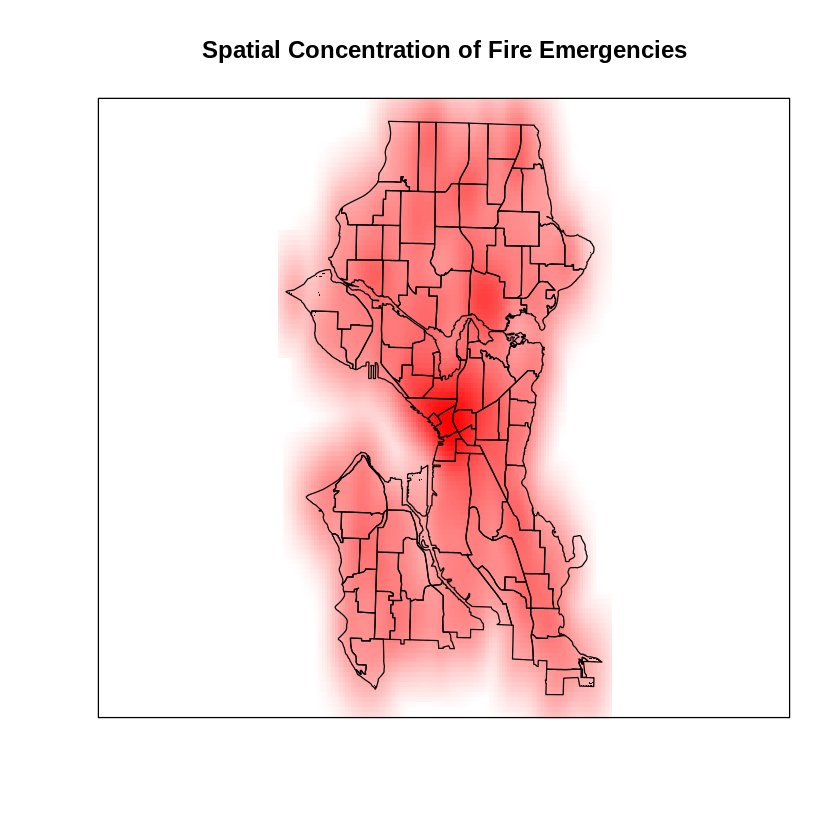

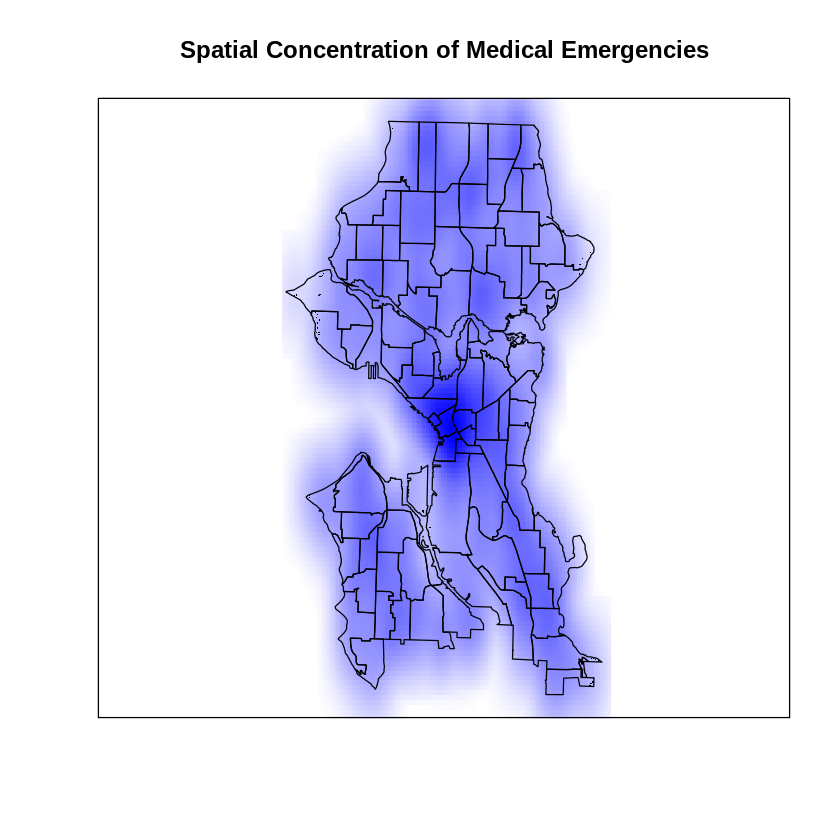

In [8]:
plot(seattle, main = 'Spatial Concentration of Fire Emergencies')
invisible(fire[ , smoothScatter(x_lon, y_lat, add = TRUE,
                                colramp = colorRampPalette(c('white', 'red')))])
plot(seattle, add = TRUE)

plot(seattle, main = 'Spatial Concentration of Medical Emergencies')
invisible(medic[ , smoothScatter(x_lon, y_lat, add = TRUE,
                                 colramp = colorRampPalette(c('white', 'blue')))])
plot(seattle, add = TRUE)